# Analisis Sentimen Ulasan Aplikasi BCA Mobile di Google Play Store Menggunakan Deep Learning

Notebook ini merupakan bagian lanjutan dari proyek analisis sentimen terhadap ulasan pengguna aplikasi BCA Mobile yang diperoleh dari Google Play Store. Setelah dilakukan scraping data, dilanjutkan dengan model training.

## Import Library

In [1]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


In [2]:
# Data handling
import pandas as pd
import numpy as np
import requests
import csv
from io import StringIO
import joblib
import gdown

# Text preprocessing
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import itertools

# Machine learning & deep learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Loading Dataset

In [3]:
# URL file Google Driv
url = 'https://drive.google.com/uc?id=1NfC0VWTeKKlXe26RhFUIlsWooWVAKzpD'
output = 'bcamobile_review.csv'

# Download file
gdown.download(url, output, quiet=False)

# Baca file CSV
bcamobile_review = pd.read_csv(output)
bcamobile_review.head()

Downloading...
From (original): https://drive.google.com/uc?id=1NfC0VWTeKKlXe26RhFUIlsWooWVAKzpD
From (redirected): https://drive.google.com/uc?id=1NfC0VWTeKKlXe26RhFUIlsWooWVAKzpD&confirm=t&uuid=3db056c1-62dd-4cb7-8c59-4861a24dfac3
To: /content/bcamobile_review.csv
100%|██████████| 213M/213M [00:02<00:00, 94.0MB/s]


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c212fde7-a595-4b8f-8ef7-6991f46ce79e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolong aplikasi di perbaiki agar tidak harus m...,2,0,2.7.4,2025-04-11 16:56:03,Mohon maaf atas ketidaknyamanannya. Saran dan ...,2025-04-11 16:58:19,2.7.4
1,da0c7196-4f5c-43ff-a3f8-932a01c48587,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,terlalu sering minta verifikasi dan biaya SMS ...,1,0,NaN,2025-04-11 16:32:12,Mohon maaf atas ketidaknyamanannya. Saran dan ...,2025-04-11 16:58:17,NaN
2,07143767-313e-4f94-9445-7e844018d532,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saat saya akan melakukan M-Transfer dan setela...,4,0,4.6.1,2025-04-11 13:35:04,Mohon maaf atas ketidaknyamanan yang Bapak/Ibu...,2025-04-11 14:58:45,4.6.1
3,44a5d464-8190-480b-a8de-7901823ecf31,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat baik,5,0,4.6.1,2025-04-11 12:36:47,Terima kasih atas ulasannya. Semoga aplikasi B...,2025-04-11 13:21:41,4.6.1
4,2daab48a-9e65-40da-8a65-04e88e84d6c7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tibatiba ngga bisa dibuka apk nya itu kenapa y...,1,0,4.6.1,2025-04-11 12:12:35,Mohon maaf atas ketidaknyamanan yang Bapak/Ibu...,2025-04-11 12:32:07,4.6.1


In [4]:
bcamobile_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501335 entries, 0 to 501334
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              501335 non-null  object
 1   userName              501335 non-null  object
 2   userImage             501335 non-null  object
 3   content               501207 non-null  object
 4   score                 501335 non-null  int64 
 5   thumbsUpCount         501335 non-null  int64 
 6   reviewCreatedVersion  396918 non-null  object
 7   at                    501335 non-null  object
 8   replyContent          467930 non-null  object
 9   repliedAt             467930 non-null  object
 10  appVersion            396918 non-null  object
dtypes: int64(2), object(9)
memory usage: 42.1+ MB


In [5]:
# missing value (null) akan dihapus
new_bca = bcamobile_review.dropna()
new_bca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371293 entries, 0 to 493147
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              371293 non-null  object
 1   userName              371293 non-null  object
 2   userImage             371293 non-null  object
 3   content               371293 non-null  object
 4   score                 371293 non-null  int64 
 5   thumbsUpCount         371293 non-null  int64 
 6   reviewCreatedVersion  371293 non-null  object
 7   at                    371293 non-null  object
 8   replyContent          371293 non-null  object
 9   repliedAt             371293 non-null  object
 10  appVersion            371293 non-null  object
dtypes: int64(2), object(9)
memory usage: 34.0+ MB


In [6]:
new_bca.duplicated().sum() # duplikat data tidak ada

np.int64(0)

## Preprocessing Text

Dilakukan preprocessing text sebelum dilakukan pelabelan, berikut beberapa fungsi yang akan diterapkan: cleaningText, casefoldingText, tokenizingText, filteringText, stemmingText, toSentence

In [7]:
# membersihkan teks
def cleaningText(text):
    text = re.sub(r'http\S+|www.\S+', '', text)              # Hapus link
    text = re.sub(r'@\w+|#\w+', '', text)                    # Hapus mention dan hashtag
    text = re.sub(r'\brt\b', '', text)                       # Hapus RT
    text = re.sub(r'\d+', '', text)                          # Hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    text = text.replace('\n', ' ')                           # Ganti newline dengan spasi
    text = text.strip()                                      # Hapus spasi di awal/akhir
    return text

In [8]:
# konversi ke lowercase
def casefoldingText(text):
    return text.lower()

In [9]:
# teks to daftar kata
def tokenizingText(text):
    return word_tokenize(text)

In [10]:
# menghapus stopwords
factory_stop = StopWordRemoverFactory()
stopwords = factory_stop.get_stop_words()

additional_stopwords = [
    'nya', 'nih', 'sih', 'kayak', 'banget', 'aja', 'dong', 'an', 'pas',
    'dari', 'ke', 'di', 'untuk', 'oleh', 'dengan', 'sama', 'itu', 'mereka',
    'ini', 'kami', 'kamu', 'lah', 'kah', 'dong', 'deh', 'eh'
]
stopwords.extend(additional_stopwords)

def filteringText(text):
    return [word for word in text if word not in stopwords]

In [11]:
# mengembalikan kata dasar
factory_stem = StemmerFactory()
stemmer = factory_stem.create_stemmer()

def stemmingText(text):
    return [stemmer.stem(word) for word in text]

In [12]:
# join daftar kata ke 1 kalimat
def toSentence(words):
    return ' '.join(words)

In [13]:
new_bca.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c212fde7-a595-4b8f-8ef7-6991f46ce79e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolong aplikasi di perbaiki agar tidak harus m...,2,0,2.7.4,2025-04-11 16:56:03,Mohon maaf atas ketidaknyamanannya. Saran dan ...,2025-04-11 16:58:19,2.7.4
2,07143767-313e-4f94-9445-7e844018d532,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saat saya akan melakukan M-Transfer dan setela...,4,0,4.6.1,2025-04-11 13:35:04,Mohon maaf atas ketidaknyamanan yang Bapak/Ibu...,2025-04-11 14:58:45,4.6.1
3,44a5d464-8190-480b-a8de-7901823ecf31,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat baik,5,0,4.6.1,2025-04-11 12:36:47,Terima kasih atas ulasannya. Semoga aplikasi B...,2025-04-11 13:21:41,4.6.1
4,2daab48a-9e65-40da-8a65-04e88e84d6c7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tibatiba ngga bisa dibuka apk nya itu kenapa y...,1,0,4.6.1,2025-04-11 12:12:35,Mohon maaf atas ketidaknyamanan yang Bapak/Ibu...,2025-04-11 12:32:07,4.6.1
5,bc5b8222-ca99-4e44-9f2c-a12eacf38a66,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,apk bgus sangat mudah,5,0,4.6.1,2025-04-11 11:53:42,Terima kasih atas ulasannya. Semoga aplikasi B...,2025-04-11 12:07:06,4.6.1


In [14]:
slangwords_bca = {
    "gk": "tidak", "ga": "tidak", "ngga": "tidak", "g": "tidak", "tdk": "tidak", "tdak": "tidak", "gak": "tidak",
    "gabisa": "tidak bisa", "ga bisa": "tidak bisa", "gbs": "tidak bisa", "gatau": "tidak tahu", "gtw": "tidak tahu",
    "udh": "sudah", "udah": "sudah", "sdh": "sudah", "blm": "belum", "blom": "belum", "td": "tadi",
    "bgt": "banget", "bgtu": "begitu", "bntu": "bantu", "bntuannya": "bantuannya", "trs": "terus", "trus": "terus", "mulu": "terus-menerus",
    "gmn": "gimana", "gimana": "bagaimana", "dpet": "dapat", "dpn": "depan", "bkin": "membuat", "bikin": "membuat",
    "buat": "untuk", "bs": "bisa", "bisa2": "bisa-bisa", "ngisi": "mengisi", "mo": "mau", "mw": "mau",
    "aj": "saja", "aja": "saja", "kl": "kalau", "klw": "kalau", "klo": "kalau", "blg": "bilang",
    "msh": "masih", "smpe": "sampai", "sampe": "sampai", "mnt": "menit", "br": "baru", "krn": "karena",
    "lg": "kembali", "sya": "saya", "sy": "saya", "aq": "aku", "aqa": "aku", "emg": "memang",
    "ampun": "tidak tahan", "pke": "pakai", "aktifin": "mengaktifkan", "trkn": "terkoneksi",
    "trhubung": "terhubung", "trsambung": "tersambung", "tf": "transfer", "atw": "atau", "jdi": "menjadi",
    "munculll": "muncul", "kmren": "kemarin", "tlong": "tolong", "tolongin": "tolong",
    "nohp": "nomor hp", "no hp": "nomor hp", "atmnya": "atm", "mbanking": "mobile banking", "m banking": "mobile banking",
    "mbca": "mobile bca", "bca nya": "bca", "bcanya": "bca", "aplikasiny": "aplikasinya", "apknya": "aplikasinya", "apk": "aplikasi",
    "versinya": "versi", "ver": "versi", "updatean": "update", "apdet": "update", "diupdate": "diperbarui",
    "rekeningnya": "rekening", "rek": "rekening", "saldoq": "saldo saya", "akunq": "akun saya", "duitq": "uang saya", "uangq": "uang saya",
    "dr": "dari", "d": "di", "sm": "sama", "pasword": "password", "pasw": "password", "pin nya": "pin",
    "kode otp": "otp", "otpnya": "otp", "loginya": "loginnya", "loginnya": "login", "gagalin": "gagal",
    "pelayanannya": "pelayanan", "customer serv": "customer service", "cs nya": "customer service", "cs nya bca": "customer service bca",
    "kira²": "kira-kira", "kece": "bagus", "mantul": "bagus", "mantap": "bagus", "keren": "bagus", "fix": "sudah pasti",
    "ribet": "sulit", "susah": "sulit", "gampang": "mudah", "ngerti": "paham", "ga ngerti": "tidak paham",
    "cashlash": "non tunai", "aman repot": "aman dan tidak repot", "no": "nomor", "kaya": "seperti", "simcard g": "simcard tidak",
    "mengendat": "mengendap", "ditmbhin": "ditambahkan", "dev": "developer", "sangat mudah tentunya": "sangat mudah",
    "tarik tunai rp": "tarik tunai", "lebih bagus bank lainnya": "lebih bagus dari bank lainnya",
    "errornya": "error", "eror": "error", "crash": "macet", "lemot": "lambat", "lambrett": "lambat",
    "lelet": "lambat", "ngelag": "lambat", "lag": "lambat", "bgus": "bagus"
}


In [15]:
def fix_slangwords(text):
    slangwords_bca = {
    }
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords_bca:
            fixed_words.append(slangwords_bca[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [16]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
new_bca['text_clean'] = new_bca['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
new_bca['text_casefoldingText'] = new_bca['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
new_bca['text_slangwords'] = new_bca['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
new_bca['text_tokenizingText'] = new_bca['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
new_bca['text_stopword'] = new_bca['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
new_bca['text_akhir'] = new_bca['text_stopword'].apply(toSentence)

<ipython-input-16-ffa998c0a466>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bca['text_clean'] = new_bca['content'].apply(cleaningText)
<ipython-input-16-ffa998c0a466>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bca['text_casefoldingText'] = new_bca['text_clean'].apply(casefoldingText)
<ipython-input-16-ffa998c0a466>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [17]:
new_bca[['content', 'text_akhir']].head()

,content,text_akhir
0,tolong aplikasi di perbaiki agar tidak harus m...,aplikasi perbaiki mematikan aksesibilitas hp d...
2,Saat saya akan melakukan M-Transfer dan setela...,melakukan mtransfer pemasukkan pin kok transak...
3,sangat baik,sangat baik
4,tibatiba ngga bisa dibuka apk nya itu kenapa y...,tibatiba ngga dibuka apk yaa padahal kemaren² ...
5,apk bgus sangat mudah,apk bgus sangat mudah


## Labeling

In [18]:
# mengambil lexicon positif dari kamus di github
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")


In [19]:
# mengambil lexicon negatif dari kamus di github
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [20]:
# karena ada beberapa kata yang tidak sesuai, sehingga dilakukan manual
# semakin jauh angka dari nol, maka semakin kuat positif negatifnya
manual_positive = {
    'sangat': 1,
    'membantu': 2,
    'bagus': 2,
    'baik': 2,
    'terima': 1,
    'kasih': 1,
    'mantap': 2,
    'mudah': 2,
    'puas': 2,
    'cepat': 2,
    'good': 2,
    'mantappp': 2,
    'top': 2,
    'good job': 2,
    'memudahkan': 2,
}

manual_negative = {
    'gagal': -3,
    'ribet': -2,
    'error': -3,
    'lemot': -2,
    'terputus': -2,
    'force close': -3,
    'verifikasi ulang': -2,
    'tidak bisa': -3,
    'masalah': -2,
    'kecewa': -3,
    'masuk': -1,
}

In [21]:
lexicon_positive.update(manual_positive)
for word in manual_positive:
    lexicon_negative.pop(word, None)

lexicon_negative.update(manual_negative)
for word in manual_negative:
    lexicon_positive.pop(word, None)

In [22]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [23]:
results = new_bca['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
new_bca['polarity_score'], new_bca['polarity'] = zip(*results)

print(new_bca['polarity'].value_counts())

polarity
positive    202105
negative     86842
neutral      82346
Name: count, dtype: int64


<ipython-input-23-049233b23afd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bca['polarity_score'], new_bca['polarity'] = zip(*results)
<ipython-input-23-049233b23afd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bca['polarity_score'], new_bca['polarity'] = zip(*results)


## Label Exploratory

<ipython-input-24-bfcaa22f19aa>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_bca, x='polarity', order=new_bca['polarity'].value_counts().index, palette='pastel')


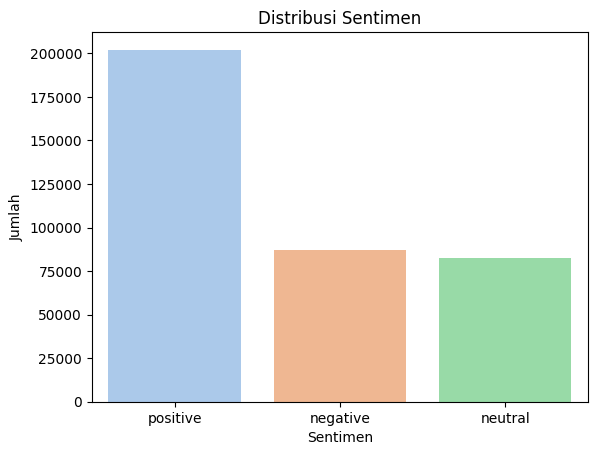

In [24]:
sns.countplot(data=new_bca, x='polarity', order=new_bca['polarity'].value_counts().index, palette='pastel')
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

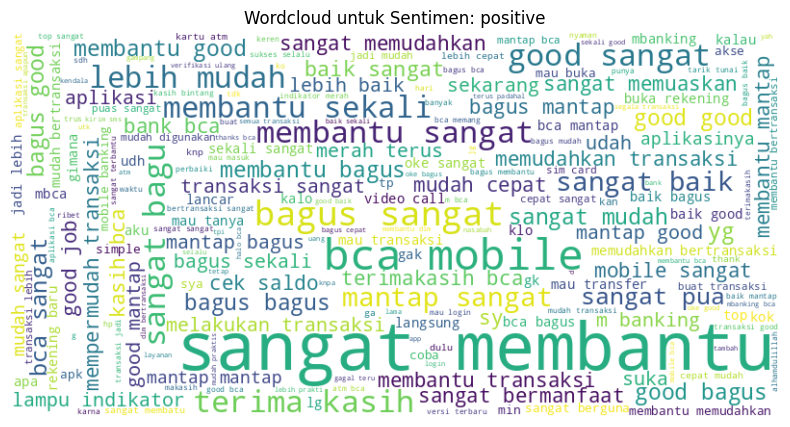

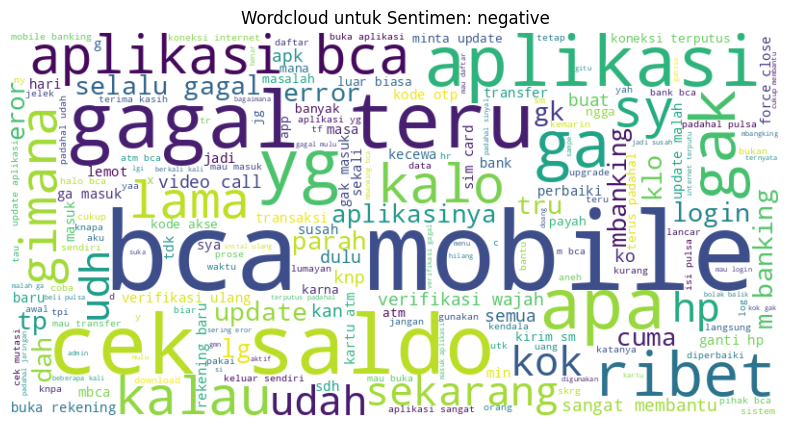

In [25]:
for label in ['positive', 'negative']:
    text = new_bca[new_bca['polarity'] == label]['text_stopword'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud untuk Sentimen: {label}')
    plt.show()


<ipython-input-26-a67024ae8add>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_df, y='word', x='count', palette='coolwarm')


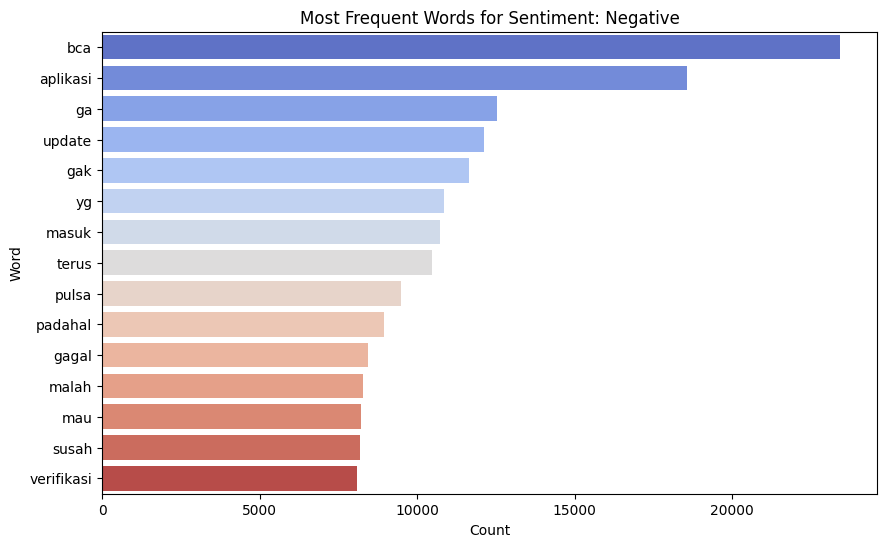

<ipython-input-26-a67024ae8add>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_df, y='word', x='count', palette='coolwarm')


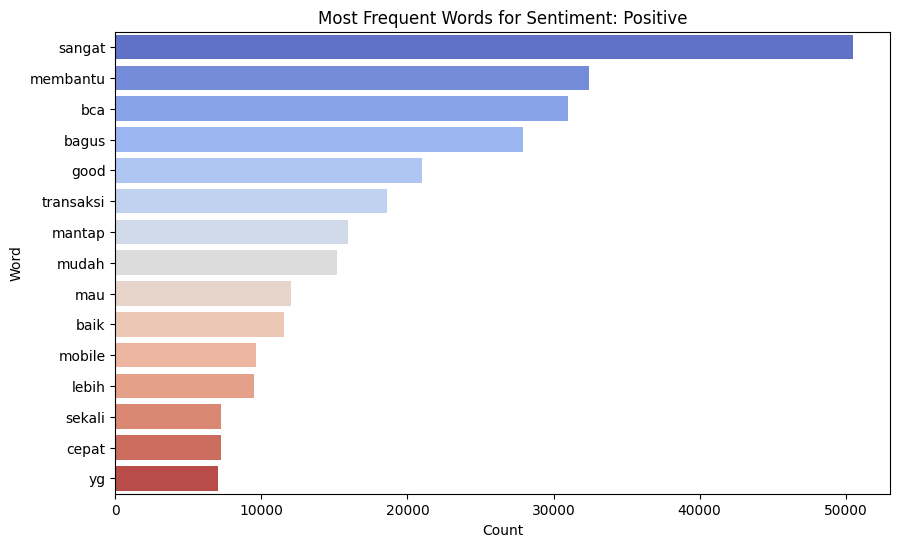

<ipython-input-26-a67024ae8add>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_df, y='word', x='count', palette='coolwarm')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


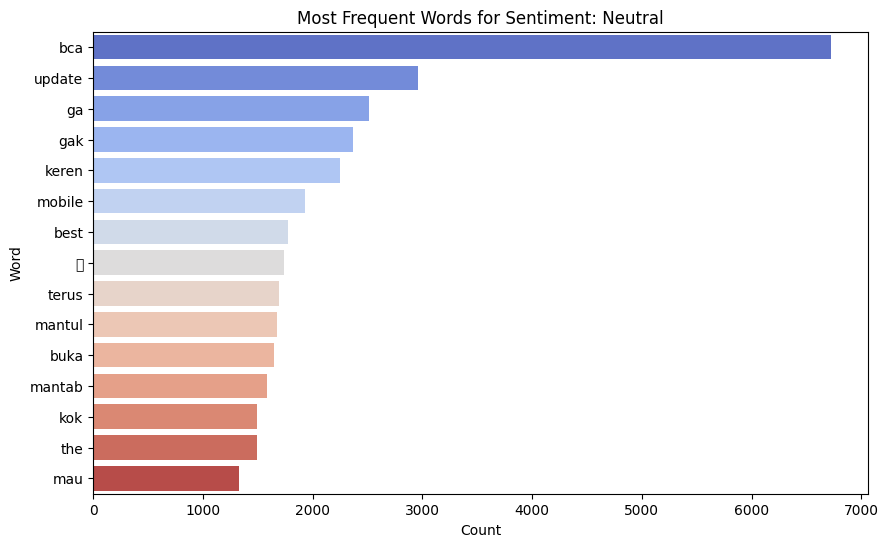

In [26]:
top_n = 15  # jumlah kata yang ditampilkan per label

for label in new_bca['polarity'].unique():
    subset = new_bca[new_bca['polarity'] == label]

    all_words = list(itertools.chain(*subset['text_akhir'].str.split()))
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(top_n)

    # Ubah ke DataFrame untuk plotting
    word_df = pd.DataFrame(common_words, columns=['word', 'count'])

    # Visualisasi
    plt.figure(figsize=(10, 6))
    sns.barplot(data=word_df, y='word', x='count', palette='coolwarm')
    plt.title(f'Most Frequent Words for Sentiment: {label.capitalize()}')
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()


## Data Splitting

In [27]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = new_bca['text_akhir']
y = new_bca['polarity']

In [28]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42, stratify=y
)

## Modeling & Evaluation

3 percobaan skema pelatihan yang berbeda. Skema ini dapat dibedakan dari variasi algoritma pelatihan, metode ekstraksi fitur, pelabelan, dan pembagian data dengan memilih minimal 2 kombinasi.

In [29]:
# Skema 1: LSTM + TF-IDF
# cocok untuk data berurutan teks
# TF-IDF setelah split (fit hanya di training biar fair)
tfidf = TfidfVectorizer(max_features=2000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Encode label ke numerik
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# One-hot encoding label
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Mengubah input ke bentuk 3D untuk LSTM
X_train_lstm = X_train_tfidf.toarray().reshape((X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1]))
X_test_lstm = X_test_tfidf.toarray().reshape((X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1]))

# Membangun model LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(1, 2000), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

# Kompilasi
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Melatih model
history = model.fit(
    X_train_lstm, y_train_cat,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_lstm, y_test_cat),
    callbacks=[early_stop]
)

# Evaluasi akurasi
train_loss, train_acc_lstm = model.evaluate(X_train_lstm, y_train_cat)
test_loss, test_acc_lstm = model.evaluate(X_test_lstm, y_test_cat)

print(f"Skema 1 - LSTM + TF-IDF\nTrain Accuracy: {train_acc_lstm:.4f}, Test Accuracy: {test_acc_lstm:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
4642/4642 ━━━━━━━━━━━━━━━━━━━━ 114s 24ms/step - accuracy: 0.8918 - loss: 0.2880 - val_accuracy: 0.9634 - val_loss: 0.1306
Epoch 2/5
4642/4642 ━━━━━━━━━━━━━━━━━━━━ 138s 23ms/step - accuracy: 0.9635 - loss: 0.1278 - val_accuracy: 0.9682 - val_loss: 0.1202
Epoch 3/5
4642/4642 ━━━━━━━━━━━━━━━━━━━━ 141s 23ms/step - accuracy: 0.9677 - loss: 0.1168 - val_accuracy: 0.9710 - val_loss: 0.1141
Epoch 4/5
4642/4642 ━━━━━━━━━━━━━━━━━━━━ 144s 23ms/step - accuracy: 0.9708 - loss: 0.1089 - val_accuracy: 0.9731 - val_loss: 0.1083
Epoch 5/5
4642/4642 ━━━━━━━━━━━━━━━━━━━━ 146s 24ms/step - accuracy: 0.9725 - loss: 0.1030 - val_accuracy: 0.9740 - val_loss: 0.1057
9283/9283 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - accuracy: 0.9788 - loss: 0.0885
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9757 - loss: 0.0999
Skema 1 - LSTM + TF-IDF
Train Accuracy: 0.9791, Test Accuracy: 0.9740


In [40]:
# Skema 2: CNN + Tokenizer + Embedding Layer
# CNN bagus untuk data teks dan menangkap pattern
# teknik embedding digunakan karena biasanya lebih baik dari TF-IDF

# Tokenisasi dan padding
max_words = 5000
max_len = 100  # panjang maksimum sekuens
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Encode label ke numerik
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# One-hot encoding label
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Bangun model CNN
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

# Kompilasi model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Training model
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=[early_stop]
)

# Evaluasi
train_loss, train_acc_cnn = model.evaluate(X_train_pad, y_train_cat)
test_loss, test_acc_cnn = model.evaluate(X_test_pad, y_test_cat)

print(f"Skema 2 - CNN + Tokenizer + Embedding\nTrain Accuracy: {train_acc_cnn:.4f}, Test Accuracy: {test_acc_cnn:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
4642/4642 ━━━━━━━━━━━━━━━━━━━━ 363s 78ms/step - accuracy: 0.8978 - loss: 0.2696 - val_accuracy: 0.9530 - val_loss: 0.1322
Epoch 2/5
4642/4642 ━━━━━━━━━━━━━━━━━━━━ 378s 77ms/step - accuracy: 0.9548 - loss: 0.1280 - val_accuracy: 0.9602 - val_loss: 0.1161
Epoch 3/5
4642/4642 ━━━━━━━━━━━━━━━━━━━━ 362s 72ms/step - accuracy: 0.9609 - loss: 0.1109 - val_accuracy: 0.9621 - val_loss: 0.1106
Epoch 4/5
4642/4642 ━━━━━━━━━━━━━━━━━━━━ 352s 76ms/step - accuracy: 0.9648 - loss: 0.1009 - val_accuracy: 0.9599 - val_loss: 0.1153
Epoch 5/5
4642/4642 ━━━━━━━━━━━━━━━━━━━━ 336s 72ms/step - accuracy: 0.9685 - loss: 0.0915 - val_accuracy: 0.9622 - val_loss: 0.1100
9283/9283 ━━━━━━━━━━━━━━━━━━━━ 104s 11ms/step - accuracy: 0.9767 - loss: 0.0702
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9620 - loss: 0.1108
Skema 2 - CNN + Tokenizer + Embedding
Train Accuracy: 0.9768, Test Accuracy: 0.9622


In [41]:
# Skema 3: SVM + TF-IDF
# model klasik ini digunakan sebagai pembanding model deep learning
# SVM cocok untuk data teks

# TF-IDF (fit hanya di data training)
tfidf = TfidfVectorizer(max_features=2000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Encode label
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Bangun model SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train_enc)

# Prediksi
y_pred_train = svm.predict(X_train_tfidf)
y_pred_test = svm.predict(X_test_tfidf)

# Evaluasi
train_acc_svm = accuracy_score(y_train_enc, y_pred_train)
test_acc_svm = accuracy_score(y_test_enc, y_pred_test)

print(f"Skema 3 - SVM + TF-IDF\nTrain Accuracy: {train_acc_svm:.4f}, Test Accuracy: {test_acc_svm:.4f}")
print("\nClassification Report (Test):\n", classification_report(y_test_enc, y_pred_test, target_names=le.classes_))


Skema 3 - SVM + TF-IDF
Train Accuracy: 0.9623, Test Accuracy: 0.9600

Classification Report (Test):
               precision    recall  f1-score   support

    negative       0.93      0.96      0.95     17369
     neutral       0.96      0.89      0.93     16469
    positive       0.97      0.99      0.98     40421

    accuracy                           0.96     74259
   macro avg       0.96      0.95      0.95     74259
weighted avg       0.96      0.96      0.96     74259



## Evaluasi

In [42]:
results_df = pd.DataFrame({
    'Scheme': [
        'LSTM + TF-IDF',
        'CNN + Tokenizer + Embedding',
        'SVM + TF-IDF'
    ],
    'Train Accuracy': [
        train_acc_lstm,
        train_acc_cnn,
        train_acc_svm
    ],
    'Test Accuracy': [
        test_acc_lstm,
        test_acc_cnn,
        test_acc_svm
    ]
})

results_df = results_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
print(results_df)


                        Scheme  Train Accuracy  Test Accuracy
0                LSTM + TF-IDF        0.979097       0.973996
1  CNN + Tokenizer + Embedding        0.976787       0.962173
2                 SVM + TF-IDF        0.962321       0.960005


Dari ketiga skema yang diuji, LSTM + TF-IDF merupakan model dengan performa terbaik. Selisih akurasi yang tipis antara data latih dan uji juga menunjukkan model ini memiliki generalisasi yang baik dan tidak mengalami overfitting. Sehingga untuk percobaan input teks baru, digunakan model skema 1

## Inference

In [33]:
# Simpan model LSTM
model.save('model_lstm.h5')

# Simpan TF-IDF dan LabelEncoder pakai joblib
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder_lstm.pkl')

['label_encoder_lstm.pkl']

In [34]:
print(model.input_shape)

(None, 1, 2000)


In [39]:
def preprocessing(sentence):
    cleaned = cleaningText(sentence)
    folded = casefoldingText(cleaned)
    slang_fixed = fix_slangwords(folded)
    tokenized = tokenizingText(slang_fixed)
    stop_removed = filteringText(tokenized)
    return toSentence(stop_removed)

# Load model and preprocessing tools
model = tf.keras.models.load_model('model_lstm.h5')
tfidf = joblib.load('tfidf_vectorizer.pkl')
label_encoder = joblib.load('label_encoder_lstm.pkl')

# User input
new_sentence = input("Enter a new sentence: ")
processed_sentence = preprocessing(new_sentence)

# TF-IDF transform dan reshape untuk LSTM input
X_new = tfidf.transform([processed_sentence]).toarray()
X_new = X_new.reshape((1, 1, 2000))

# Buat prediksi
prediction = model.predict(X_new)
predicted_class = np.argmax(prediction, axis=1)
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"The sentiment of the new sentence is: {predicted_label[0].upper()}")

Enter a new sentence: verifikasi buat login susah dan aplikasi sering error
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
The sentiment of the new sentence is: NEGATIVE
